<a href="https://colab.research.google.com/github/nitish-01/optimisation/blob/main/Optimal_control_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Optimal control problems


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

## Minimum energy control Problem


$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$



We consider optimal vehicle guidance problem with state $x_t\in\R^4$, where the first two states are the position of the vehicle in two dimensions, and the last two are the vehicle velocity. The vehicle's control force $u_t\in\R^2$ is acceleration control for the two axes.

Then the following matrices describe the above dynamics.

$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
B = \bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
} 
$$

We consider the finite horizon of $T=50$, with $\Delta t=0.05$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

We used the constraints describing the dynamical relations, $x_{t+1} = Ax_t + Bu_t$ in order to eleminate the state variables, $x_1, \dots,x_N$, from the optimization problem. That way we were able to express the problem as a standard form least norm problem with the optimization variable $u_0,\dots,u_{N-1}$. The resulting problem looked like

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \|u\|_2^2 \\
  \text{subject to} \quad & Gu = x_\text{des}-A^Nx_0
\end{aligned}
$$

where $G=\bmat{A^{N-1}B & A^{N-2}B & \cdots & AB & B}$ and $u=\bmat{u_1^T & \cdots & u_{N-1}^T}^T$. The desired final position and velocity vector is expressed in $x_\text{des}$ and $x_0$ describes the initial condition. 

The following was an implementation of this idea.

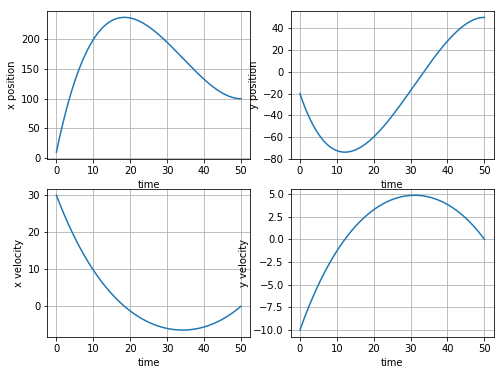

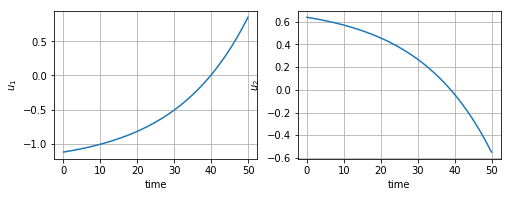

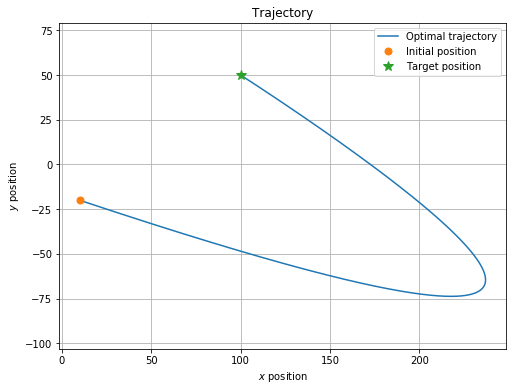

In [ ]:
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

x_0 = np.array([10, -20, 30, -10])
x_des = np.array([100, 50, 0, 0])

G = np.zeros((4,2*N))

for i in range(N):
  G[:, 2*i:2*(i+1)] = np.linalg.matrix_power(A,max(0,N-i-1))@B

u_hat = sla.lsqr(G,x_des - np.linalg.matrix_power(A,N)@x_0)[0]

u_vec = u_hat

u_opt = u_vec.reshape(1000,2).T

x_opt = np.zeros((4,N+1))
x_opt[:,0] = x_0

for t in range(N):
    x_opt[:,t+1] = A.dot(x_opt[:,t]) + B.dot(u_opt[:,t])

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

## Minimum energy control with `cvxpy`

The original non-standard form with the optimization variables $u_0,\dots,u_{N-1}, x_1,\dots,x_N$, and the original dynamic constraints as linear equality constraints on the optimization variables.

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$

We will just put this form into `cvxpy`.


-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 6004, constraints m = 4008
          nnz(P) + nnz(A) = 16008
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+02   1.00e+04   1.00e-01   1.19e-02s
  50   7.2872e+02   2.80e-04   1.35e-07   1.01e-02   1.90e-02s
plsh   7.3611e+02   1.67e-11   2.93e-11   --------   2.72e-

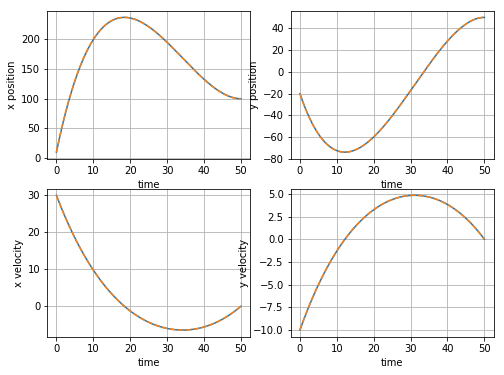

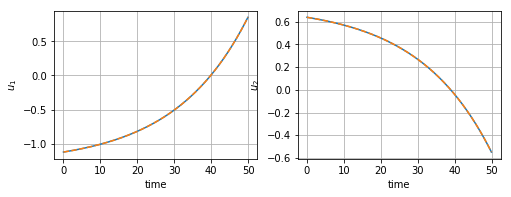

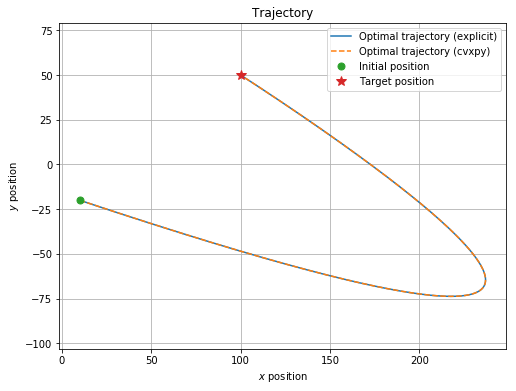

In [ ]:
import cvxpy as cp

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A*x[:,t] + B*u[:,t] ]

cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], label='Optimal trajectory (explicit)')
plt.plot(x_cp[0,:],x_cp[1,:], '--', label='Optimal trajectory (cvxpy)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

In [ ]:
x_diff = x_cp - x_opt
u_diff = u_cp - u_opt

print (np.linalg.norm(x_diff))
print (np.linalg.norm(u_diff))

2.6384614102049813e-06
3.100259424841349e-08


## Minimum energy control with state limits

Suppose our vehicle is limited to move inside some rectangular area. It is like our robot vaccum searching for the minimum energy trajectory inside the (rectangular) room. 

So the problem can be described by

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N
\end{aligned}
$$

where $C$ chooses the position vector from a state variable,

$$
  C = \bmat{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0}
$$

and $p_\text{lb}$ and $p_\text{ub}$ describe the boundary of the rectangle.


-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 6004, constraints m = 8008
          nnz(P) + nnz(A) = 20008
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+02   1.00e+04   1.00e-01   1.59e-02s
 200   1.0553e+03   1.65e+00   2.98e-02   7.42e-03   6.50e-02s
 400   8.7779e+02   1.60e-01   1.27e-03   7.42e-03   1.46e-

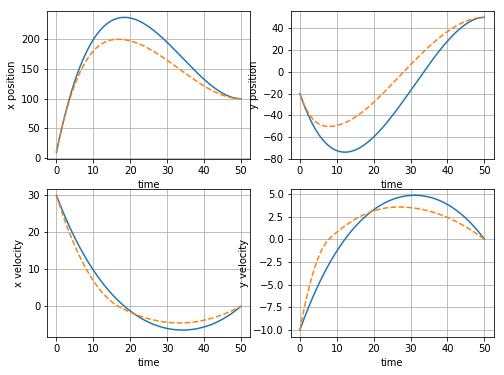

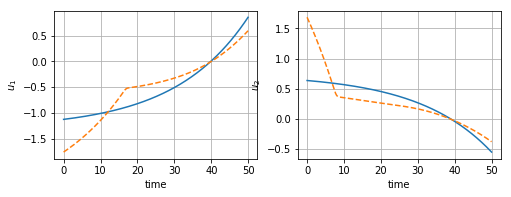

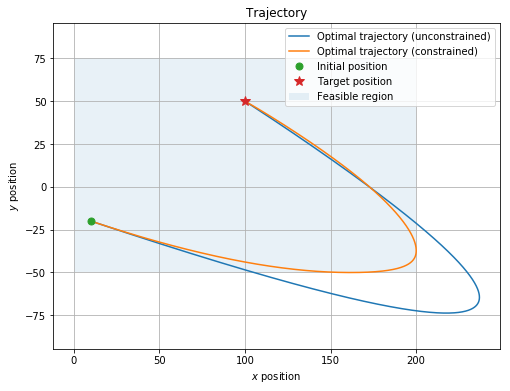

In [ ]:
import cvxpy as cp

##########################################
p_lb = np.array([  0, -50])
p_ub = np.array([200,  75])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
##########################################

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A*x[:,t] + B*u[:,t] ]
    ####################################################
    constr += [ p_lb <= C*x[:,t+1], C*x[:,t+1] <= p_ub ]
    ####################################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], \
         label='Optimal trajectory (unconstrained)')
plt.plot(x_cp[0,:],x_cp[1,:], \
         label='Optimal trajectory (constrained)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

## Minimum energy control with state and control limits

We impose additional constraints on control forces. This is quite natural, since any control system has physical limits on its control forces.

So the problem can be described by

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$

Let's just code it.

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 6004, constraints m = 12008
          nnz(P) + nnz(A) = 24008
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+02   1.00e+04   1.00e-01   1.62e-02s
 200   1.0224e+03   1.26e+00   4.96e-02   1.69e-02   5.32e-02s
 400   9.6840e+02   8.60e-01   9.29e-03   1.69e-02   1.48e

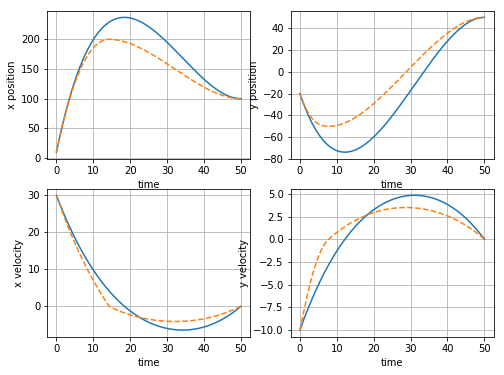

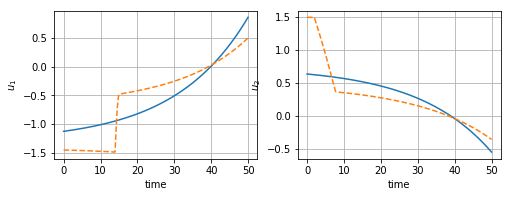

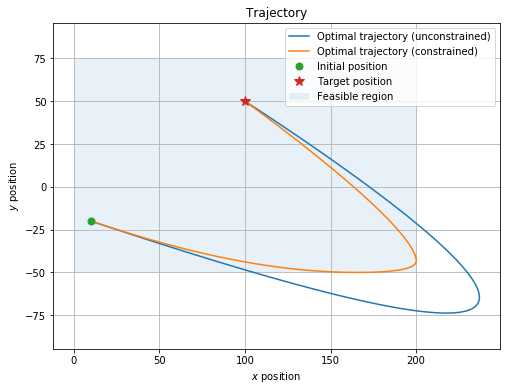

In [ ]:
import cvxpy as cp

#############################
u_lb = np.array([-1.5, -1.5])
u_ub = np.array([ 1.5,  1.5])
#############################

p_lb = np.array([  0, -50])
p_ub = np.array([200,  75])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A*x[:,t] + B*u[:,t] ]
    constr += [ p_lb <= C*x[:,t+1], C*x[:,t+1] <= p_ub ]
    ############################################
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    ############################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], \
         label='Optimal trajectory (unconstrained)')
plt.plot(x_cp[0,:],x_cp[1,:], \
         label='Optimal trajectory (constrained)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

## Minimum 'something else' optimal control

We consider different objective functions, in order to examine how the different objectives affect your optimal solutions.

First consider the sum (not squared-sum) of the 2-norm of $u_t$, which can be seen as the $\ell_1$ norm of $\left(\|u_0\|_2, \dots, \|u_{N-1}\|_2\right)$. 
Note that the $\ell_1$ norm of  $\left( \|u_0\|_2, \dots, \|u_{N-1}\|_2 \right)$ is $\|u_0\|_2 + \cdots + \|u_{N-1}\|_2$ and the $\ell_2$ norm of  $\left( \|u_0\|_2, \dots, \|u_{N-1}\|_2 \right)$ is $\left(\|u_0\|_2^2 + \cdots + \|u_{N-1}\|_2^2\right)^{1/2}$

$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.310e+05  +9e+05  2e-01  1e-01  1e+00  9e+01    ---    ---    2  1  - |  -  - 
 1  -1.090e+03  -1.132e+05  +3e+05  8e-02  1e-02  2e+01  4e+01  0.9019  3e-01   1  1  1 |  0  0
 2  -1.101e+03  -5.607e+04  +2e+05  4e-02  4e-03  1e+01  2e+01  0.5160  1e-01   1  1  1 |  0  0
 3  -5.303e+02  -1.280e+04  +5e+04  8e-03  5e-04  3e+00  5e+00  0.7952  6e-02   1  1  1 |  0  0
 4  +1.136e+02  -3.394e+03  +1e+04  2e-03  1e-04  7e-01  2e+00  0.7641  1e-01   1  1  1 |  0  0
 5  +3.992e+02  -8.256e+02  +5e+03  6e-04  4e-05  2e-01  6e-01  0.6629  6e-02   1  1  1 |  0  0
 6  +5.522e+02  +4.918e+01  +2e+03  2e-04  2e-05  1e-01  3e-01  0.6106  6e-02   1  1  1 |  0  0
 7  +5.884e+02  +3.224e+02  +1e+03  1e-04  1e-05  5e-02  1e-01  0.7473  4e-01   1  1  1 |  0  0
 8  +6.313e+02  +5.776e+02  +3e+02  3e-05  2e-

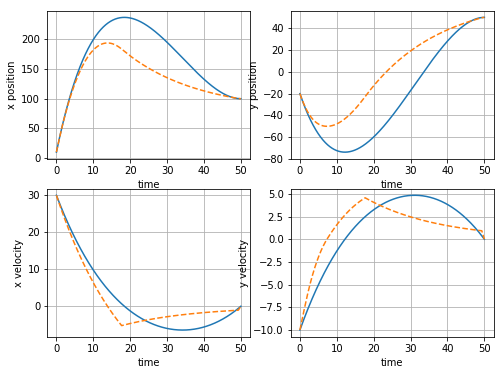

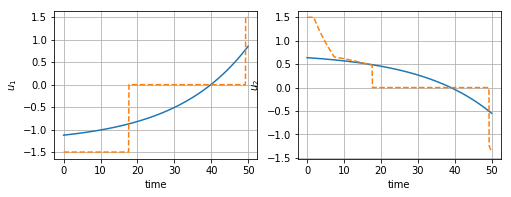

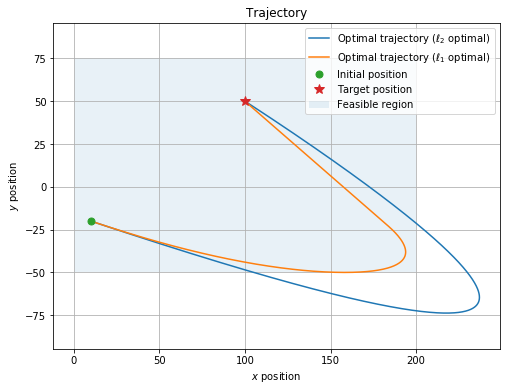

In [ ]:
import cvxpy as cp

#############################
u_lb = np.array([-1.5, -1.5])
u_ub = np.array([ 1.5,  1.5])
#############################

p_lb = np.array([  0, -50])
p_ub = np.array([200,  75])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = 0
for t in range(N):
  obj += cp.norm(u[:,t],2)
obj = cp.Minimize(obj)

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A*x[:,t] + B*u[:,t] ]
    constr += [ p_lb <= C*x[:,t+1], C*x[:,t+1] <= p_ub ]
    ############################################
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    ############################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], \
         label=r'Optimal trajectory ($\ell_2$ optimal)')
plt.plot(x_cp[0,:],x_cp[1,:], \
         label=r'Optimal trajectory ($\ell_1$ optimal)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

Maximum of the 2-norm of $u_t$, which can be seen as the $\ell_{\infty}$ norm of $\left(\|u_0\|_2, \dots, \|u_{N-1}\|_2\right)$. 
$$
\begin{aligned}
  \underset{u_0,\dots,u_{N-1}, x_1,\dots,x_N}{\minimize} \quad & \max_t \|u_t\|_2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1 \\
  & p_\text{lb} \le C x_t \le p_\text{ub}, \qquad & t=1,\dots,N \\
  & u_\text{lb} \le u_t \le u_\text{ub}, \qquad & t=0,\dots,N-1
\end{aligned}
$$


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.310e+05  +8e+05  2e-01  1e+01  1e+00  8e+01    ---    ---    1  1  - |  -  - 
 1  +1.068e+02  -1.294e+05  +3e+05  9e-02  8e-01  2e+01  3e+01  0.8516  4e-01   1  1  1 |  0  0
 2  +1.281e+02  -4.141e+04  +1e+05  3e-02  2e-01  8e+00  1e+01  0.6943  1e-01   1  1  1 |  0  0
 3  +1.284e+02  -1.087e+04  +4e+04  7e-03  3e-02  2e+00  4e+00  0.8048  1e-01   1  1  1 |  0  0
 4  +1.109e+02  -3.763e+03  +1e+04  2e-03  8e-03  7e-01  1e+00  0.6839  1e-01   1  1  1 |  0  0
 5  +7.014e+01  -4.556e+02  +2e+03  3e-04  2e-03  7e-02  2e-01  0.8569  2e-02   1  1  1 |  0  0
 6  +1.171e+01  -1.275e+01  +1e+02  1e-05  7e-04  2e-03  1e-02  0.9488  3e-03   1  1  1 |  0  0
 7  +2.913e+00  -2.774e+00  +3e+01  2e-06  7e-04  4e-04  3e-03  0.8011  5e-02   1  1  1 |  0  0
 8  +2.113e+00  -4.903e-01  +1e+01  1e-06  7e-

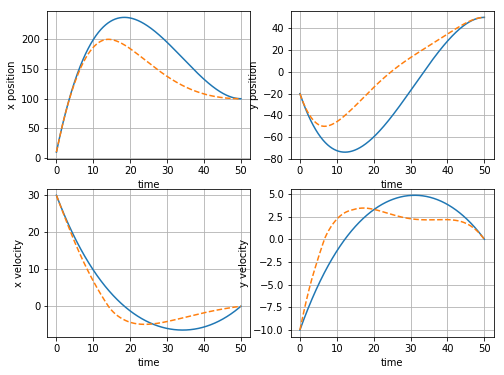

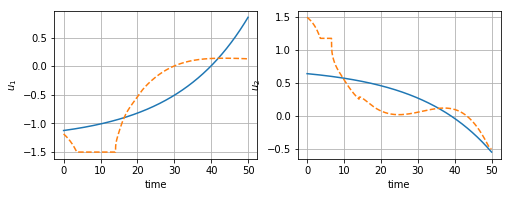

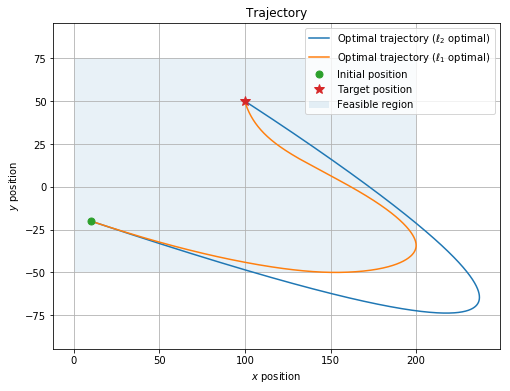

In [ ]:
import cvxpy as cp

#############################
u_lb = np.array([-1.5, -1.5])
u_ub = np.array([ 1.5,  1.5])
#############################

p_lb = np.array([  0, -50])
p_ub = np.array([200,  75])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

x = cp.Variable((4,N+1))  # x_{0},...,x_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.max(cp.norm(u, 2, axis=0)))

constr = [ x[:,-1] == x_des, 
           x[:,0]  == x_0    ]
for t in range(N):
    constr += [ x[:,t+1] == A*x[:,t] + B*u[:,t] ]
    constr += [ p_lb <= C*x[:,t+1], C*x[:,t+1] <= p_ub ]
    ############################################
    constr += [ u_lb <= u[:,t], u[:,t] <= u_ub ]
    ############################################
    
cp.Problem(obj, constr).solve(verbose=True)

x_cp = np.array(x.value)
u_cp = np.array(u.value)

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts,x_opt[0,:])
plt.plot(ts,x_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_opt[1,:])
plt.plot(ts,x_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_opt[2,:])
plt.plot(ts,x_cp[2,:], '--')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_opt[3,:])
plt.plot(ts,x_cp[3,:], '--')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.plot(ts[:-1],u_cp[0,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.plot(ts[:-1],u_cp[1,:], '--')
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x_opt[0,:],x_opt[1,:], \
         label=r'Optimal trajectory ($\ell_2$ optimal)')
plt.plot(x_cp[0,:],x_cp[1,:], \
         label=r'Optimal trajectory ($\ell_1$ optimal)')
plt.plot(x_0[0], x_0[1], 'o', markersize=7, label='Initial position')
plt.plot(x_des[0], x_des[1], '*', markersize=10, label='Target position')
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()    

In order to get a better intuition behind these effects, let us consider a 1 dimensional unconstrained problem.


In [ ]:
N = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping, 0 is no damping

A1 = np.zeros((2,2))
B1 = np.zeros((2,1))
C1 = np.zeros((1,2))

A1[0,0] = 1
A1[0,1] = (1-gamma*delt/2)*delt
A1[1,1] = 1 - gamma*delt

B1[0,0] = delt**2/2
B1[1,0] = delt

x_01 = np.array([10, 30])
x_des1 = np.array([100, 0])

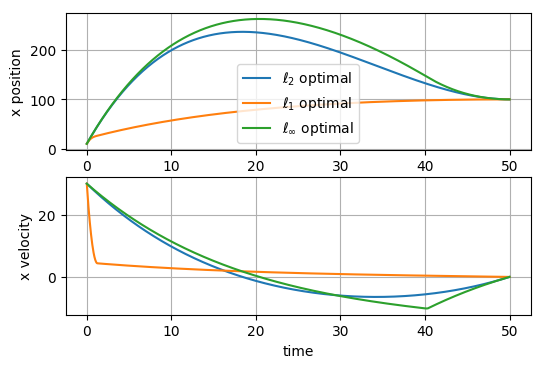

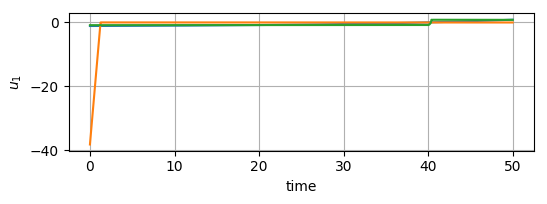

In [ ]:
import cvxpy as cp

x = cp.Variable((2,N+1))  # x_{0},...,x_{N}
u = cp.Variable((1,N))    # u_{0},...,u_{N-1}

obj2 = cp.Minimize(cp.norm(u))

constr = [ x[:,-1] == x_des1, 
           x[:,0]  == x_01    ]
for t in range(N):
    constr += [ x[:,t+1] == A1*x[:,t] + B1*u[:,t] ]
    
cp.Problem(obj2, constr).solve()
x_cp2 = np.array(x.value)
u_cp2 = np.array(u.value)

obj1 = cp.Minimize(cp.norm1(u))
cp.Problem(obj1, constr).solve()
x_cp1 = np.array(x.value)
u_cp1 = np.array(u.value)

obji = cp.Minimize(cp.norm_inf(u))
cp.Problem(obji, constr).solve()
x_cpi = np.array(x.value)
u_cpi = np.array(u.value)

plt.figure(dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts,x_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts,x_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x_cp2[1,:], label=r'$\ell_2$ optimal')
plt.plot(ts,x_cp1[1,:], label=r'$\ell_1$ optimal')
plt.plot(ts,x_cpi[1,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.show()

plt.figure(dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],u_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts[:-1],u_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts[:-1],u_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.show()


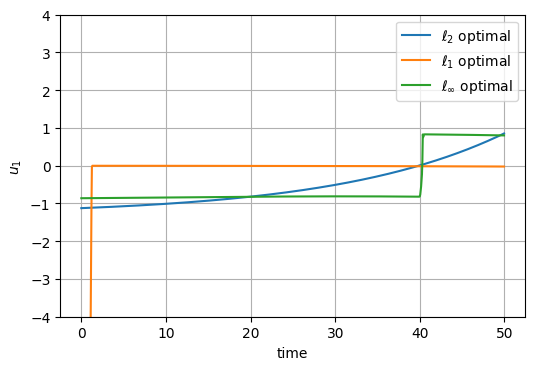

In [ ]:
plt.figure(dpi=100)
plt.plot(ts[:-1],u_cp2[0,:], label=r'$\ell_2$ optimal')
plt.plot(ts[:-1],u_cp1[0,:], label=r'$\ell_1$ optimal')
plt.plot(ts[:-1],u_cpi[0,:], label=r'$\ell_\infty$ optimal')
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.legend()
plt.ylim(-4, 4)
plt.grid()
plt.show()